# Music Generator with LSTM

## About

Music resamples language as a temporal sequence of articulated sounds. They say something, often something human.

Although, there are crucial differences between language and music. We can still describe it as a sequence of symbols in the simplest form of understanding. Translating something complex into something simpler, but usable by computational models.

Thus, the objective of this project is to establish a communication between the human, that understands music in the most intense way that the brain can interpret through information, and the machine.

We'll create a model that can generate music based on the input information, i.e., generate a sequence of sounds which are related in some way with the sounds passed as input.

We'll use Natural Language Processing (NLP) methods, observing the music as it were a language, abstracting it. Doing this, the machine can recognize and process similar data.

On the first step, we'll use text generation techniques, using Recurrent Neural Networks (RNNs) and Long-Short Term Memories (LSTMs). With the effectiveness of the training, even if it's reasonable, we'll perform the same implementation using specific methods such as Attention.



## Imports

In [72]:
# Basic libraries
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Preprocessing data libraries
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

# Model libraries
import torch
import torch.nn as nn
import torch.optim as optim

# Data visualization
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm #for loading bars

# Utils
import music21
import pickle

In [73]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [74]:
from encoder import *
from decoder import *

## Dataset

### Load data

In [75]:
data_path = '../data/'
out_encoded_path = '../encoded/'
out_decoded_path = '../decoded/'
file = 'C major scale'
in_file = data_path + file
out_encoded = out_encoded_path + file
out_decoded = out_decoded_path + file

N_FRAMES = 36
N_NOTES = 88
MIDI_OFFSET = 20

In [76]:
# be sure that the dirs exist
if not os.path.isdir(data_path):
    os.mkdir(data_path)
if not os.path.isdir(out_decoded_path):
    os.mkdir(out_decoded_path)
if not os.path.isdir(out_encoded_path):
    os.mkdir(out_encoded_path)

In [77]:
# get encoded data and save encoded file
encoded_song = encode_data(in_file,
                           N_FRAMES,
                           N_NOTES,
                           MIDI_OFFSET, 
                           save_as=out_encoded
                           )

Encoding file C_major_scale
Encoding Piano
Took 0.30590081214904785


### Data visualization

Each song is represented by a Pandas DataFrame where each column represents some song status. 

In [78]:
encoded_song

,inst_code,ks,bpm,ts,G#0,A0,B-0,B0,C1,C#1,...,D7,E-7,E7,F7,F#7,G7,G#7,A7,B-7,B7
inst,,,,,,,,,,,,,,,,,,,,,
Piano,0,C,120.0,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Piano,0,C,120.0,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Piano,0,C,120.0,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Piano,0,C,120.0,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Piano,0,C,120.0,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Piano,0,C,120.0,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Piano,0,C,120.0,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Piano,0,C,120.0,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [79]:
test_piano_df = encoded_song[encoded_song.index=='Piano']
# test_bass_df = encoded_song[encoded_song.index=='Bass']
print(f'Number of frames: {len(test_piano_df.index)}')
print(f'Number of bars: {len(test_piano_df.index)//N_FRAMES}')
test_piano_df

Number of frames: 288
Number of bars: 8


,inst_code,ks,bpm,ts,G#0,A0,B-0,B0,C1,C#1,...,D7,E-7,E7,F7,F#7,G7,G#7,A7,B-7,B7
inst,,,,,,,,,,,,,,,,,,,,,
Piano,0,C,120.0,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Piano,0,C,120.0,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Piano,0,C,120.0,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Piano,0,C,120.0,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Piano,0,C,120.0,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Piano,0,C,120.0,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Piano,0,C,120.0,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Piano,0,C,120.0,4/4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [80]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(test_piano_df.iloc[5*36:6*36])

      inst_code ks    bpm   ts    G#0     A0    B-0     B0     C1    C#1  \
inst                                                                       
Piano         0  C  120.0  4/4  False  False  False  False  False  False   
Piano         0  C  120.0  4/4  False  False  False  False  False  False   
Piano         0  C  120.0  4/4  False  False  False  False  False  False   
Piano         0  C  120.0  4/4  False  False  False  False  False  False   
Piano         0  C  120.0  4/4  False  False  False  False  False  False   
Piano         0  C  120.0  4/4  False  False  False  False  False  False   
Piano         0  C  120.0  4/4  False  False  False  False  False  False   
Piano         0  C  120.0  4/4  False  False  False  False  False  False   
Piano         0  C  120.0  4/4  False  False  False  False  False  False   
Piano         0  C  120.0  4/4  False  False  False  False  False  False   
Piano         0  C  120.0  4/4  False  False  False  False  False  False   
Piano       

### Preprocess data

In [81]:
def get_stackframe(encoded_song, init_idx, final_idx, to_float=True):
    stackframe = encoded_song.iloc[init_idx:final_idx, 4:]
    stackframe = stackframe.to_numpy()

    # print(f'Stackframe shape: {stackframe.shape}')
    if to_float:
        stackframe.astype(float)
        stackframe = stackframe + 0.0

    return stackframe

In [82]:
def get_info(encoded_song, num_frames=N_FRAMES):
    infos = encoded_song.iloc[:num_frames, 0:4]
    return infos

In [83]:
infos = get_info(test_piano_df, len(test_piano_df))

In [84]:
import os
def create_dataset(root_dir, instrument, N_FRAMES=36):
    dataset = []
    for filename in os.listdir(root_dir):
        if filename.endswith('pkl'):
            infile = open(root_dir + filename,'rb')
            encoded_song = pickle.load(infile)
            infile.close()
            encoded_part = encoded_song[encoded_song.index==instrument]
            
            init_idx = 0
            final_idx = len(encoded_part)
            stackframe = get_stackframe(encoded_part, init_idx=init_idx, final_idx=final_idx)
            dataset.append(np.array(stackframe))
      
    return dataset

In [85]:
root_dir = '../encoded/'
instrument = 'Piano'

dataset = create_dataset(root_dir, instrument)
print(f'Dataset size: {len(dataset)} song(s)')
dataset[0]

Dataset size: 1 song(s)


array([[0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       ...,
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0]], dtype=object)

In [247]:
def split_dataset(dataset, n_frames=N_FRAMES):
    X = []
    y = []
    
    # create two arrays X, y with bars
    for song in dataset:
        # create the frame blocks shifted in one position
        for i in range(song.shape[0] - N_FRAMES):
            j = i + n_frames
            xa = song[i:j]
            ya = song[i+1:j+1]
            X.append(xa)
            y.append(ya)
        
    X = np.array(X, dtype='float64')
    y = np.array(y, dtype='float64')
    X = torch.from_numpy(X)
    y = torch.from_numpy(y)
    print(f'X.shape, y.shape: {X.shape, y.shape}')
    train_ds = TensorDataset(X, y) # (X, y)
    return train_ds

In [248]:
train_ds = split_dataset(dataset)
train_dl = DataLoader(train_ds, batch_size=1, shuffle=False)

X.shape, y.shape: (torch.Size([252, 36, 88]), torch.Size([252, 36, 88]))


In [249]:
torch.set_printoptions(threshold=10_000)
x_ds = train_ds[180][0]
y = train_ds[180][1]

x = test_piano_df.iloc[5*36:6*36]
x.A5

inst
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Piano    False
Name: A5, dtype: object

## Model

Some important definitions

In [250]:
windows_size = N_FRAMES
keyboard_size = 88
n_bars_input = len(train_dl.dataset.tensors[0]) # number of rows of the dataloader
num_layers = 4
hidden_size = 88
num_epochs = 3
batch_size = 1
lr = 0.003
print('Number of bars in the input dataset: {}'.format(n_bars_input))

Number of bars in the input dataset: 252


In [273]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    #self.embed = nn.Embedding(input_size, hidden_size)
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=False)
    self.fc = nn.Linear(hidden_size, output_size)
    self.relu = nn.ReLU()
    self.softplus = nn.Softplus(beta=500, threshold=0)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x, hidden, cell):

    # Passing in the input and hidden state into the model and obtaining outputs
    out, (hidden, cell) = self.lstm(x.unsqueeze(1), (hidden, cell))

    # Reshaping the outputs such that it can be fit into the fully connected layer
    #print(torch.squeeze(out[-1]))
    out = out.contiguous().view(-1, self.hidden_size)
    #print('Shape2: ',out.shape)
    out = self.fc(out)
    #print('Shape3: ',out.shape)
    out = self.sigmoid(out)
    
    return out, (hidden, cell)

  def init_hidden(self, batch_size):
    # This method generates the first hidden state of zeros which we'll use in the forward pass
    # We'll send the tensor holding the hidden state to the device we specified earlier as well
    hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
    cell = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
    return hidden, cell

In [274]:
# Instantiate the model with hyperparameters
# We'll also set the model to the device that we defined earlier (default is CPU)
model = RNN(input_size=keyboard_size,
                   output_size=keyboard_size,
                   hidden_size=hidden_size,
                   num_layers=num_layers).to(device)

In [275]:
print(model)


RNN(
  (lstm): LSTM(88, 88, num_layers=4)
  (fc): Linear(in_features=88, out_features=88, bias=True)
  (relu): ReLU()
  (softplus): Softplus(beta=500, threshold=0)
  (sigmoid): Sigmoid()
)


## Train

In [276]:
# converts one frame into torch tensor
def multi_hot_tensor(frame):
  tensor = torch.from_numpy(frame)
  return tensor

In [277]:
# retrieve data from dataloader
def get_sample(dataloader):

  input = torch.zeros(n_bars_input, windows_size, keyboard_size)
  target = torch.zeros(n_bars_input, windows_size, keyboard_size)

  for sample, (xb, yb) in enumerate(dataloader): # gets the samples
    input[sample] = xb
    target[sample] = yb
  
  return input, target

In [291]:
def train(model, optimizer, loss_fn, dataloader, batch_size=1, num_epochs=3):
    writer = SummaryWriter()

    print("\nStarting training...")

    for epoch in range(1, num_epochs + 1):
        count = 0
        training_loss = 0.0

        print('> EPOCH #', epoch)

        input, target = get_sample(dataloader)
        input = input.to(device)
        target = target.to(device)
        
        # Initialize hidden and cells
        hidden, cell = model.init_hidden(batch_size)

        for fb_i in tqdm(range(len(train_dl.dataset.tensors[0]))):


            # Generate predictions
            frame_block = input[fb_i,:]
            output, (hidden, cell) = model(frame_block, hidden, cell)
            
            #if count%36 == 0:
                #print(f'Input {frame_block}, \nTarget {target[fb_i, :]}')

            # Compute the loss and backpropag
            loss_step = loss_fn(output, target[fb_i, :])

            hidden = hidden.detach()
            cell = cell.detach()

            count += 1
            #if count%36 == 0:
                #print(f'Output {output}, \nTarget {target[fb_i, :]}')

            loss_step.backward() # Does backpropagation and calculates gradients
            optimizer.step() # Updates the weights accordingly
            optimizer.zero_grad() # Clears existing gradients from previous frame

            training_loss += loss_step.item()

        training_loss /= len(train_dl.dataset)
        writer.add_scalar("Loss/train", training_loss, epoch)

        if epoch%1 == 0:
          print('Epoch: {}/{}.............'.format(epoch, num_epochs), end=' ')
          print("Loss: {:.8f}".format(training_loss))

    writer.flush()
    writer.close()

In [292]:
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCELoss()
train(model, optimizer, loss_fn, train_dl, num_epochs=10)

  1%|          | 2/252 [00:00<00:13, 18.54it/s]


Starting training...
> EPOCH # 1


  1%|          | 2/252 [00:00<00:13, 18.60it/s]

Epoch: 1/10............. Loss: 0.01489118
> EPOCH # 2


  1%|          | 3/252 [00:00<00:10, 24.70it/s]

Epoch: 2/10............. Loss: 0.01504607
> EPOCH # 3


  1%|          | 3/252 [00:00<00:10, 24.77it/s]

Epoch: 3/10............. Loss: 0.01441551
> EPOCH # 4


  1%|          | 3/252 [00:00<00:08, 29.00it/s]

Epoch: 4/10............. Loss: 0.01587015
> EPOCH # 5


  1%|          | 3/252 [00:00<00:10, 24.74it/s]

Epoch: 5/10............. Loss: 0.01593217
> EPOCH # 6


  1%|          | 3/252 [00:00<00:08, 27.82it/s]

Epoch: 6/10............. Loss: 0.01493748
> EPOCH # 7


  1%|          | 3/252 [00:00<00:08, 29.44it/s]

Epoch: 7/10............. Loss: 0.01448900
> EPOCH # 8


  1%|          | 3/252 [00:00<00:11, 22.60it/s]

Epoch: 8/10............. Loss: 0.01495516
> EPOCH # 9


  0%|          | 1/252 [00:00<00:34,  7.33it/s]

Epoch: 9/10............. Loss: 0.01409133
> EPOCH # 10


100%|██████████| 252/252 [00:14<00:00, 17.99it/s]

Epoch: 10/10............. Loss: 0.01471825


In [293]:
# !tensorboard --logdir=runs

## Test

In [294]:
def unroll_bars(bars, n_frames=N_FRAMES):

    output = []
    init_idx = 0
    final_idx = len(bars)
    stackframe = get_stackframe(bars, init_idx=init_idx, final_idx=final_idx)

    return np.array(stackframe, dtype='float64')

In [295]:
@torch.no_grad()
def generate(model, previous_bars, n_frames=N_FRAMES, temperature=0.5, batch_size=1):
    hidden, cell = model.init_hidden(batch_size)

    unrolled = torch.from_numpy(
                    unroll_bars(previous_bars, n_frames)
    ).float().to(device)


    # amount of frameblocks in the context input
    context_fb_n = len(unrolled) - n_frames

    # getting context iterating over
    # N-1 of the frameblocks
    for i in range(context_fb_n):
        context_fb = unrolled[i:i + n_frames]

        # we dont care about the output here.
        # we are just feeding the model with the
        # context we received as input
        _, (hidden, cell) = model(context_fb,
                                  hidden, cell)


    # we must get the output from the last context fb
    last_fb = unrolled[context_fb_n:]
    out, (hidden, cell) = model(last_fb,
                                hidden, cell)


    out = np.where(out >= (1-temperature), True, False)
    print(out, out.shape)
    return out

Decoding instrument: Piano
Took 0.32261228561401367


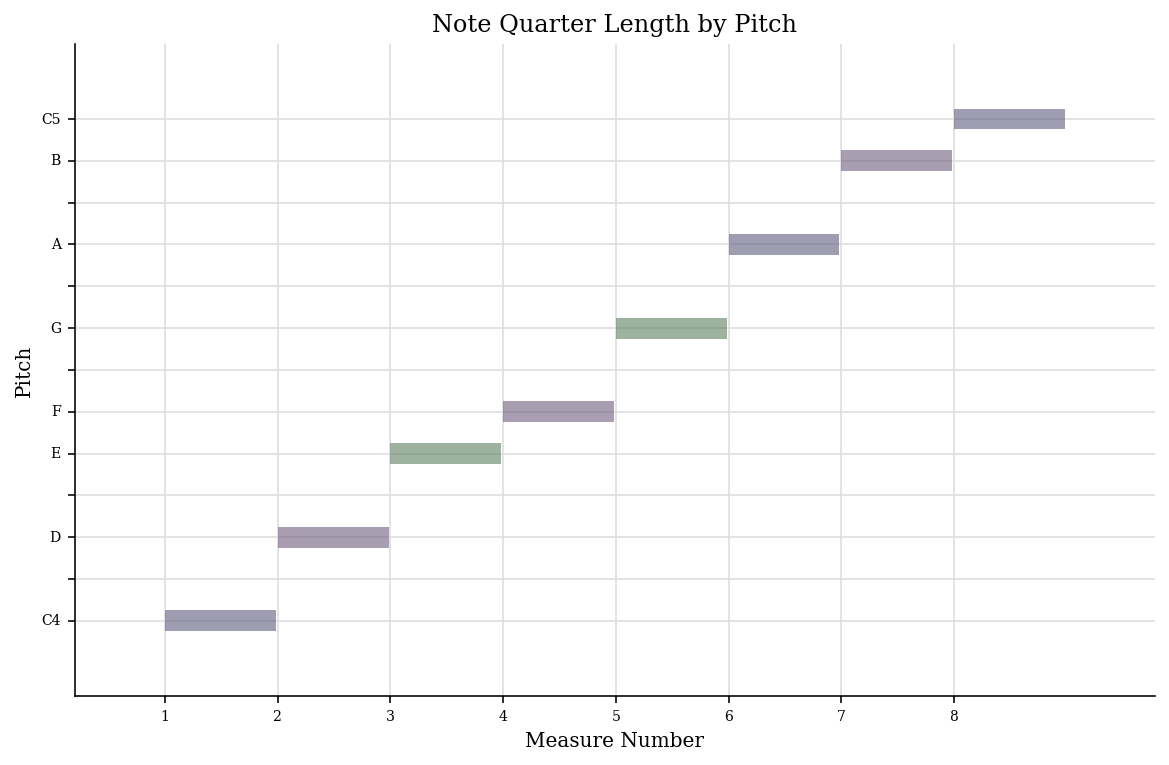

In [296]:
test_scale_df = encoded_song[encoded_song.index=='Piano']
decode_data(test_scale_df, N_FRAMES).plot()

In [297]:
def create_decoded_song(bars, infos):
    num_bars = bars.shape[0]
    columns = [key_index2note(i, MIDI_OFFSET).nameWithOctave for i in range(bars.shape[2])]
    df_decoded_song = pd.DataFrame([], columns=columns)
    
    for idx_bar in range(num_bars):
        indexes = [infos.index[0] for i in range(bars[idx_bar].shape[0])]
        df_decoded_bar = pd.DataFrame(bars[idx_bar], columns=columns).set_index(pd.Index(indexes)) 
        df_decoded_song = df_decoded_song.append(df_decoded_bar) 

    df_decoded_song.index.name = 'inst'
    output = pd.concat([infos, df_decoded_song], axis=1)
    return output

In [298]:
def create_decoded_bar(bar, infos):

    columns = [key_index2note(i, MIDI_OFFSET).nameWithOctave for i in range(bar.shape[1])]

    indexes = [infos.index[0] for i in range(bar.shape[0])]
    df_decoded_bar = pd.DataFrame(bar, columns=columns).set_index(pd.Index(indexes))
    df_decoded_bar.index.name = 'inst'
    print(infos.shape, df_decoded_bar.shape)
    output = pd.concat([infos, df_decoded_bar], axis=1)
    return output


## Previous

Decoding instrument: Piano
Took 0.1772158145904541


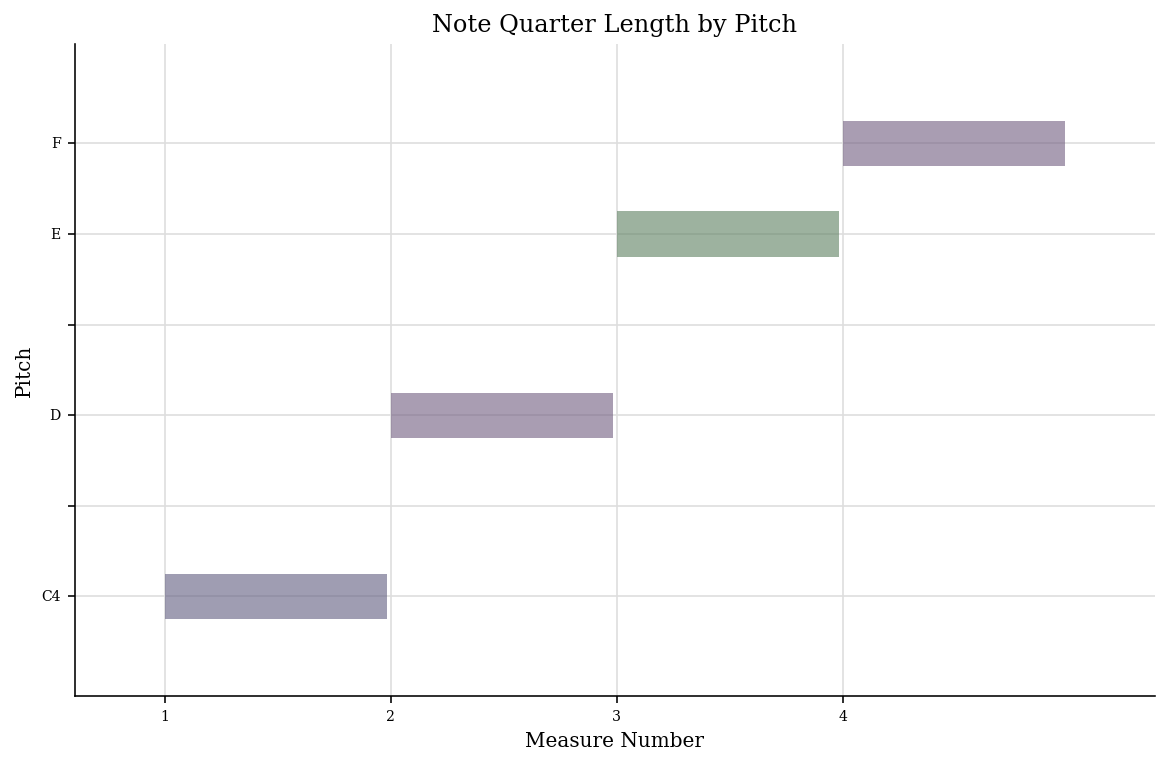

In [302]:
first = 0
last = 4

previous = test_scale_df.iloc[0:N_FRAMES*last]
s_previous = decode_data(previous, N_FRAMES)

s_previous.plot()

## Gerated Output

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]] (36, 88)
(36, 4) (36, 88)
inst
Piano    True
Piano    True
Piano    True
Piano    True
Piano    True
Piano    True
Piano    True
Piano    True
Piano    True
Piano    True
Piano    True
Piano    True
Piano    True
Piano    True
Piano    True
Piano    True
Piano    True
Piano    True
Piano    True
Piano    True
Piano    True
Piano    True
Piano    True
Piano    True
Piano    True
Piano    True
Piano    True
Piano    True
Piano    True
Piano    True
Piano    True
Piano    True
Piano    True
Piano    True
Piano    True
Piano    True
Name: C5, dtype: bool
Decoding instrument: Piano
Took 0.10634660720825195


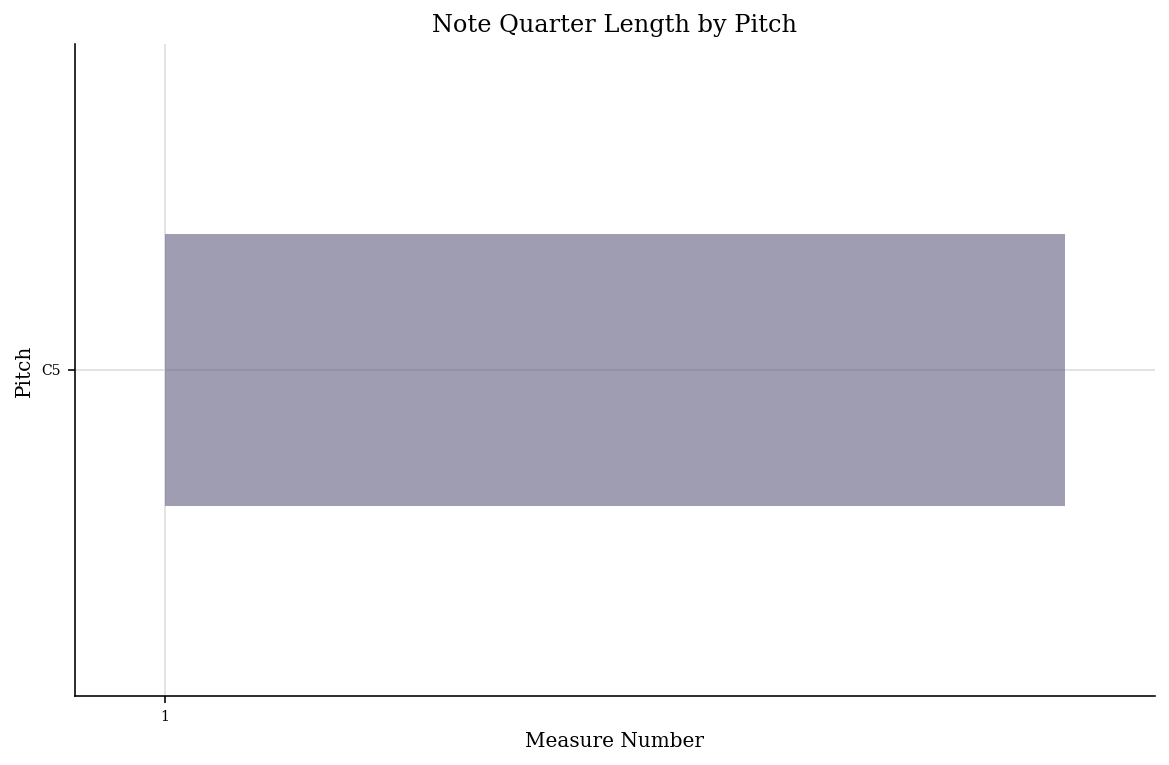

In [303]:
output = generate(model, previous, N_FRAMES, temperature=0.6)
output_info = get_info(test_piano_df[-(1+N_FRAMES):-1], N_FRAMES)
output_df = create_decoded_bar(output, output_info)

print(output_df.C5)
s_output = decode_data(output_df, N_FRAMES)


try:    s_output.plot()
except Exception as e: print(e)

## Previous + Gerated Output

Decoding instrument: Piano
Took 0.2302875518798828


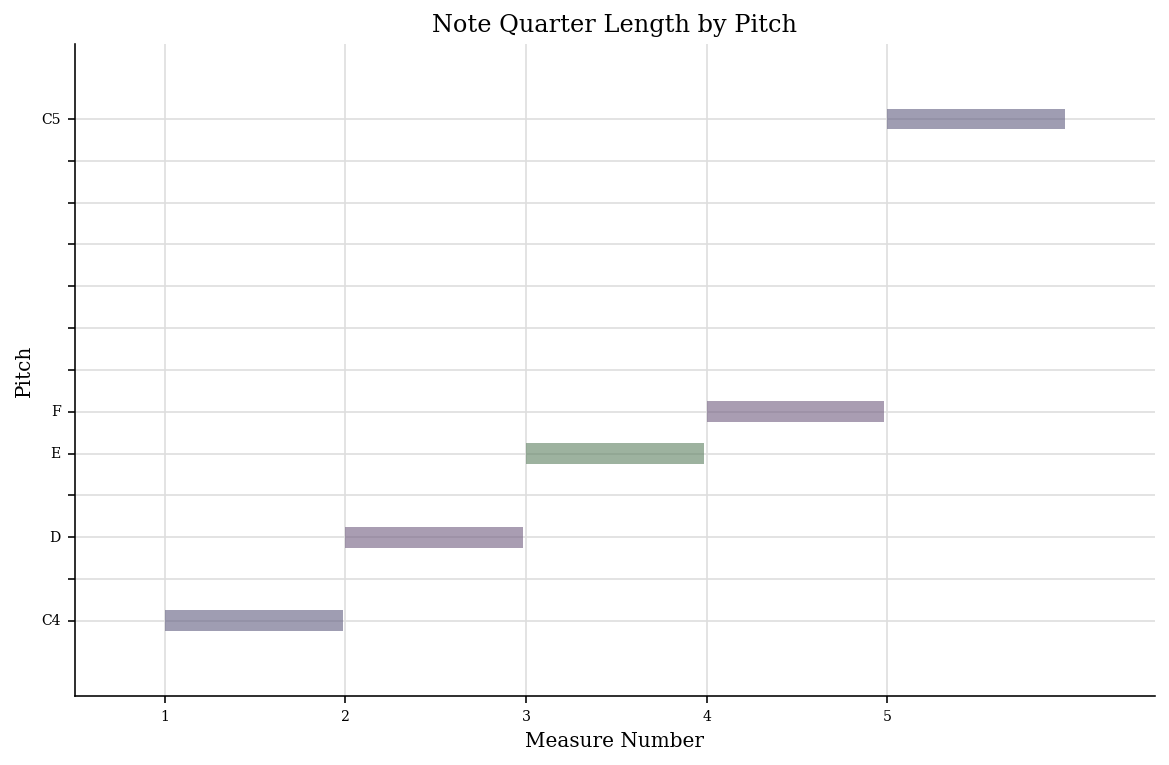

In [304]:
concat_output = pd.concat([previous, output_df], axis=0)
s_concat_output = decode_data(concat_output, N_FRAMES)
s_concat_output.plot()

